# 05 훈련 노하우를 배웁니다

이 노트북을 주피터 노트북 뷰어(nbviewer.jupyter.org)로 보거나 구글 코랩(colab.research.google.com)에서 실행할 수 있습니다.

<table class="tfo-notebook-buttons" align="left">
  <td>
    <a target="_blank" href="https://nbviewer.org/github/rickiepark/do-it-dl/blob/master/Ch05.ipynb"><img src="https://jupyter.org/assets/share.png" width="60" />주피터 노트북 뷰어로 보기</a>
  </td>
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/rickiepark/do-it-dl/blob/master/Ch05.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png" />구글 코랩(Colab)에서 실행하기</a>
  </td>
</table>

In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# Matplotlib은 기본적으로  '-'(빼기, 음수 부호) 표시가 제대로 표기되지 않는다. 그와 동시에 아래와 같은 경고메시지를 출력한다.
# UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from current font.func(*args, **kwargs)
# 해결법
plt.rcParams['axes.unicode_minus'] = False

## 05-1 검증 데이터를 준비합니다

In [3]:
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split

In [4]:
cancer = load_breast_cancer()
x = cancer.data
y = cancer.target
x_train_all, x_test, y_train_all, y_test = train_test_split(x, y, stratify=y, 
                                                            test_size=0.2, random_state=42)

In [5]:
from sklearn.linear_model import SGDClassifier

In [6]:
sgd = SGDClassifier(loss='log_loss', random_state=42)
sgd.fit(x_train_all, y_train_all)
sgd.score(x_test, y_test)

0.8333333333333334

In [7]:
sgd = SGDClassifier(loss='hinge', random_state=42)
sgd.fit(x_train_all, y_train_all)
sgd.score(x_test, y_test)

0.9385964912280702

In [8]:
x_train, x_val, y_train, y_val = train_test_split(x_train_all, y_train_all, stratify=y_train_all, 
                                                  test_size=0.2, random_state=42)

In [9]:
print(len(x_train), len(x_val))

364 91


In [10]:
sgd = SGDClassifier(loss='log_loss', random_state=42)
sgd.fit(x_train, y_train)
sgd.score(x_val, y_val)

0.6923076923076923

['mean perimeter' 'mean area']


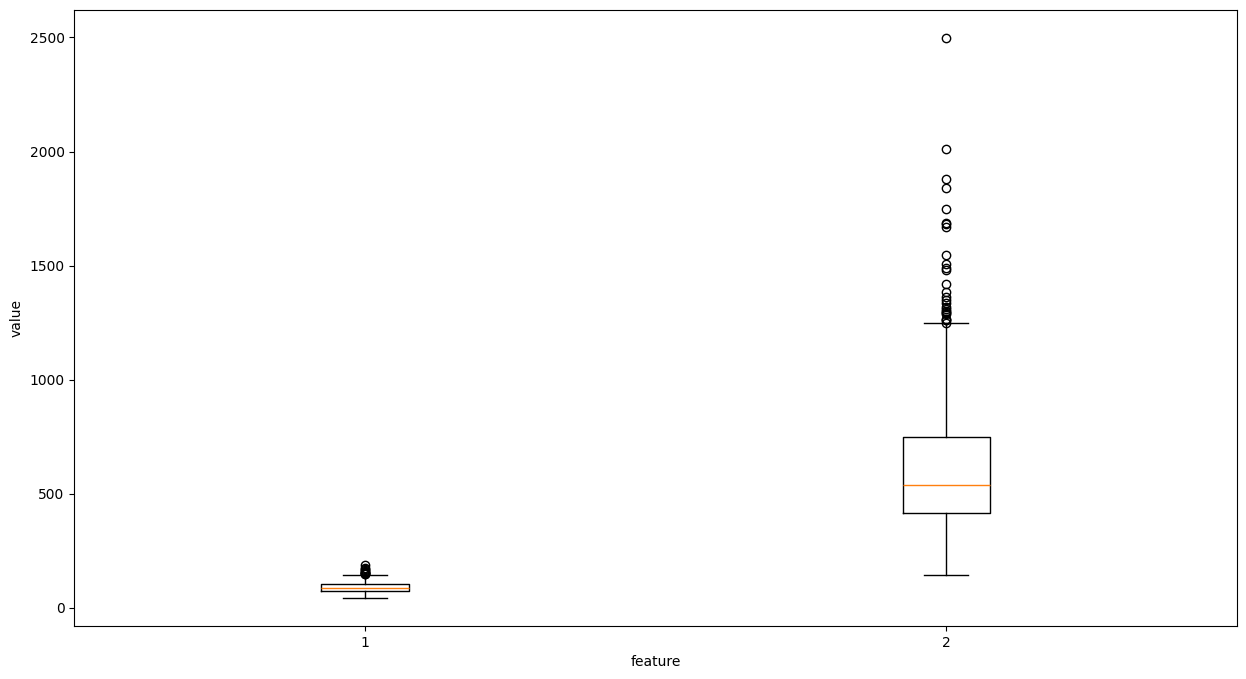

In [11]:
print(cancer.feature_names[[2,3]])
plt.figure(figsize=(15,8))
plt.boxplot(x_train[:, 2:4])
plt.xlabel('feature')
plt.ylabel('value')
plt.show()

In [12]:
class SingleLayer:
    
    def __init__(self, learning_rate=0.1, l1=0, l2=0):
        self.w = None
        self.b = None
        self.losses = []
        self.val_losses = []
        self.w_history = []
        self.lr = learning_rate
        self.l1 = l1
        self.l2 = l2

    def forpass(self, x):
        z = np.sum(x * self.w) + self.b    # 직선 방정식을 계산합니다
        return z

    def backprop(self, x, err):
        w_grad = x * err          # 가중치에 대한 그래디언트를 계산합니다
        b_grad = 1 * err    # 절편에 대한 그래디언트를 계산합니다
        return w_grad, b_grad

    def activation(self, z):
        z = np.clip(z, -100, None) # 안전한 np.exp() 계산을 위해
        a = 1 / (1 + np.exp(-z))  # 시그모이드 계산
        return a
        
    def fit(self, x, y, epochs=100, x_val=None, y_val=None):
        self.w = np.ones(x.shape[1])               # 가중치를 초기화합니다.
        self.b = 0                                 # 절편을 초기화합니다.
        self.w_history.append(self.w.copy())       # 가중치를 기록합니다.
        np.random.seed(42)                         # 랜덤 시드를 지정합니다.
        for i in range(epochs):                    # epochs만큼 반복합니다.
            loss = 0
            # 인덱스를 섞습니다
            indexes = np.random.permutation(np.arange(len(x)))
            for i in indexes:                      # 모든 샘플에 대해 반복합니다
                z = self.forpass(x[i])             # 정방향 계산
                a = self.activation(z)             # 활성화 함수 적용
                err = -(y[i] - a)                  # 오차 계산
                w_grad, b_grad = self.backprop(x[i], err) # 역방향 계산
                # 그래디언트에서 페널티 항의 미분 값을 더합니다
                w_grad += self.l1 * np.sign(self.w) + self.l2 * self.w
                self.w -= self.lr * w_grad         # 가중치 업데이트
                self.b -= self.lr * b_grad         # 절편 업데이트
                # 가중치를 기록합니다.
                self.w_history.append(self.w.copy())
                # 안전한 로그 계산을 위해 클리핑한 후 손실을 누적합니다
                a = np.clip(a, 1e-10, 1-1e-10)
                loss += -(y[i]*np.log(a)+(1-y[i])*np.log(1-a))
            # 에포크마다 평균 손실을 저장합니다
            self.losses.append(loss/len(y) + self.reg_loss())
            # 검증 세트에 대한 손실을 계산합니다
            self.update_val_loss(x_val, y_val)
    
    def predict(self, x):
        z = [self.forpass(x_i) for x_i in x]     # 정방향 계산
        return np.array(z) >= 0                   # 스텝 함수 적용
    
    def score(self, x, y):
        return np.mean(self.predict(x) == y)
    
    def reg_loss(self):
        return self.l1 * np.sum(np.abs(self.w)) + self.l2 / 2 * np.sum(self.w**2)
    
    def update_val_loss(self, x_val, y_val):
        if x_val is None:
            return
        val_loss = 0
        for i in range(len(x_val)):
            z = self.forpass(x_val[i])     # 정방향 계산
            a = self.activation(z)         # 활성화 함수 적용
            a = np.clip(a, 1e-10, 1-1e-10)
            val_loss += -(y_val[i]*np.log(a)+(1-y_val[i])*np.log(1-a))
        self.val_losses.append(val_loss/len(y_val) + self.reg_loss())

In [13]:
layer1 = SingleLayer()
layer1.fit(x_train, y_train)
layer1.score(x_val, y_val)

0.9120879120879121

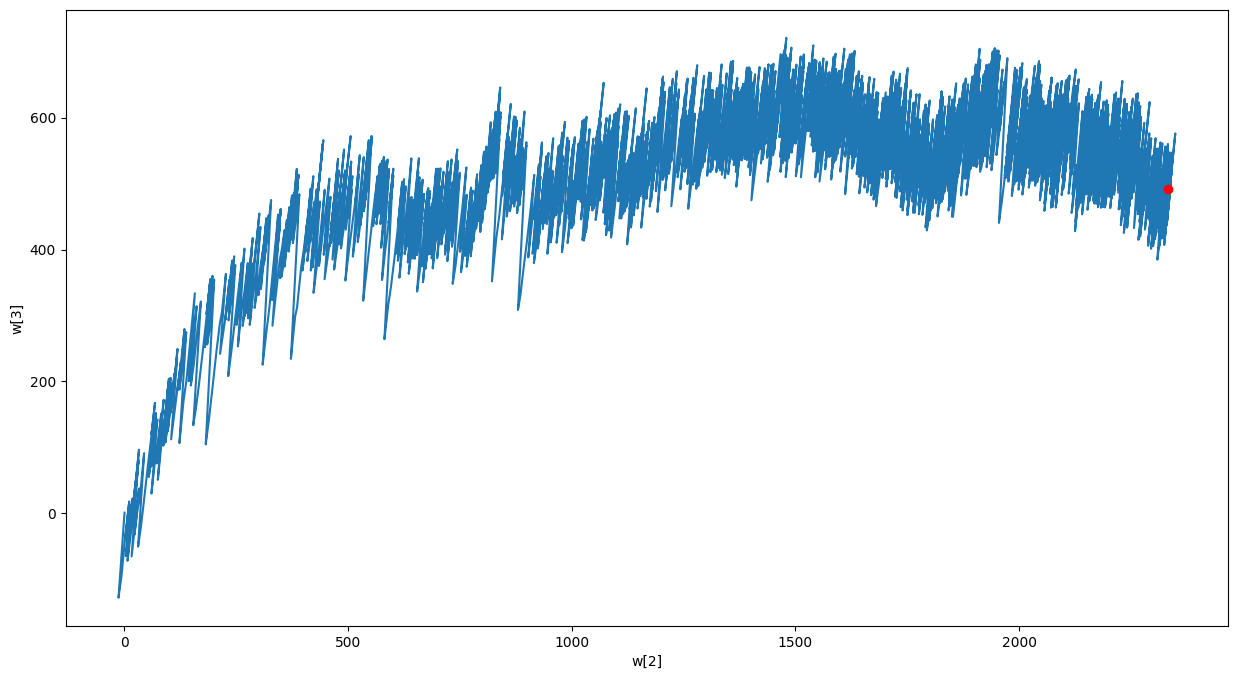

2332.594400273708 491.24740993261946


In [14]:
w2 = []
w3 = []
for w in layer1.w_history:
    w2.append(w[2])
    w3.append(w[3])
plt.figure(figsize=(15,8))
plt.plot(w2, w3)
plt.plot(w2[-1], w3[-1], 'ro')
plt.xlabel('w[2]')
plt.ylabel('w[3]')
plt.show()
print(w2[-1], w3[-1])

In [15]:
train_mean = np.mean(x_train, axis=0)
train_std = np.std(x_train, axis=0)
x_train_scaled = (x_train - train_mean) / train_std

In [16]:
layer2 = SingleLayer()
layer2.fit(x_train_scaled, y_train)

['mean perimeter' 'mean area']


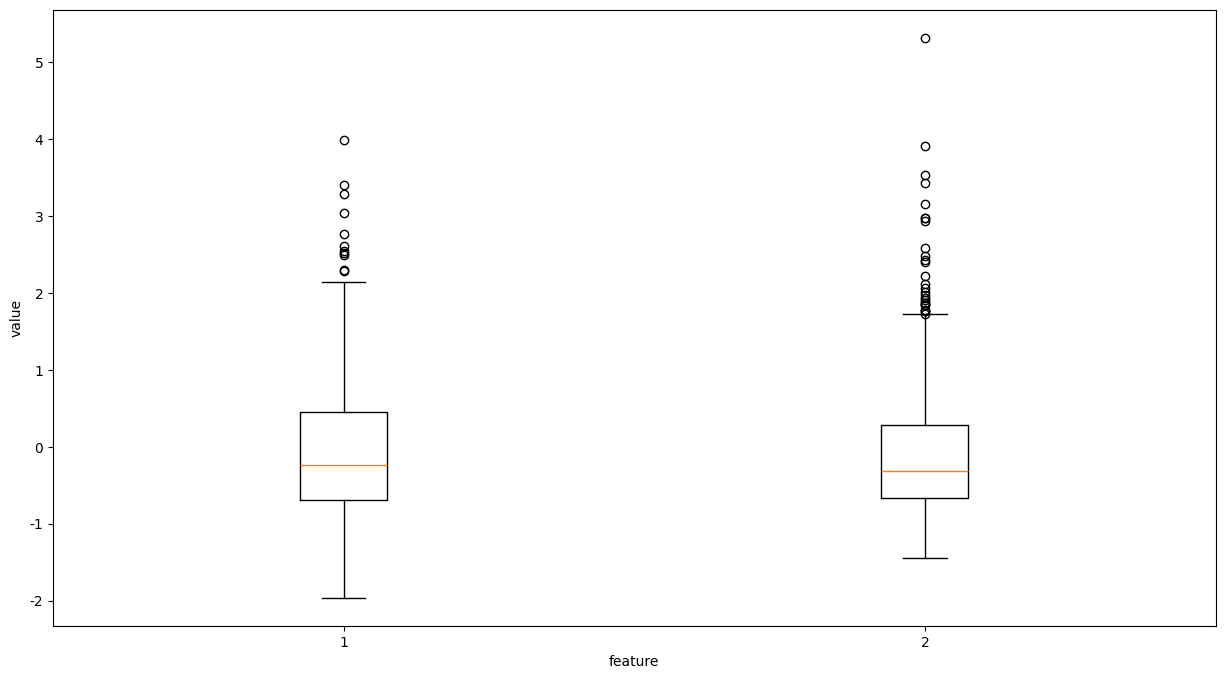

In [17]:
print(cancer.feature_names[[2,3]])
plt.figure(figsize=(15,8))
plt.boxplot(x_train_scaled[:, 2:4])
plt.xlabel('feature')
plt.ylabel('value')
plt.show()

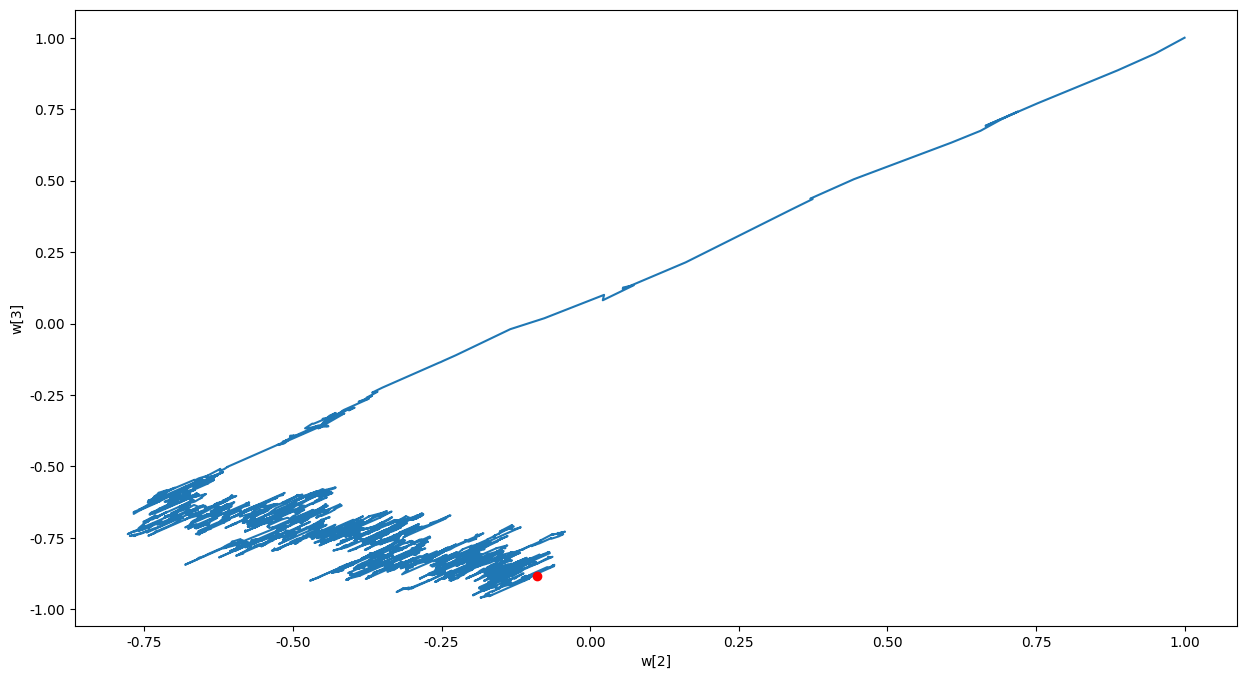

-0.0886854635062194 -0.8824167139872365


In [18]:
w2 = []
w3 = []
for w in layer2.w_history:
    w2.append(w[2])
    w3.append(w[3])
plt.figure(figsize=(15,8))
plt.plot(w2, w3)
plt.plot(w2[-1], w3[-1], 'ro')
plt.xlabel('w[2]')
plt.ylabel('w[3]')
plt.show()
print(w2[-1], w3[-1])

In [19]:
layer2.score(x_val, y_val)

0.37362637362637363

In [20]:
val_mean = np.mean(x_val, axis=0)
val_std = np.std(x_val, axis=0)
x_val_scaled = (x_val - val_mean) / val_std

In [21]:
layer2.score(x_val_scaled, y_val)

0.967032967032967

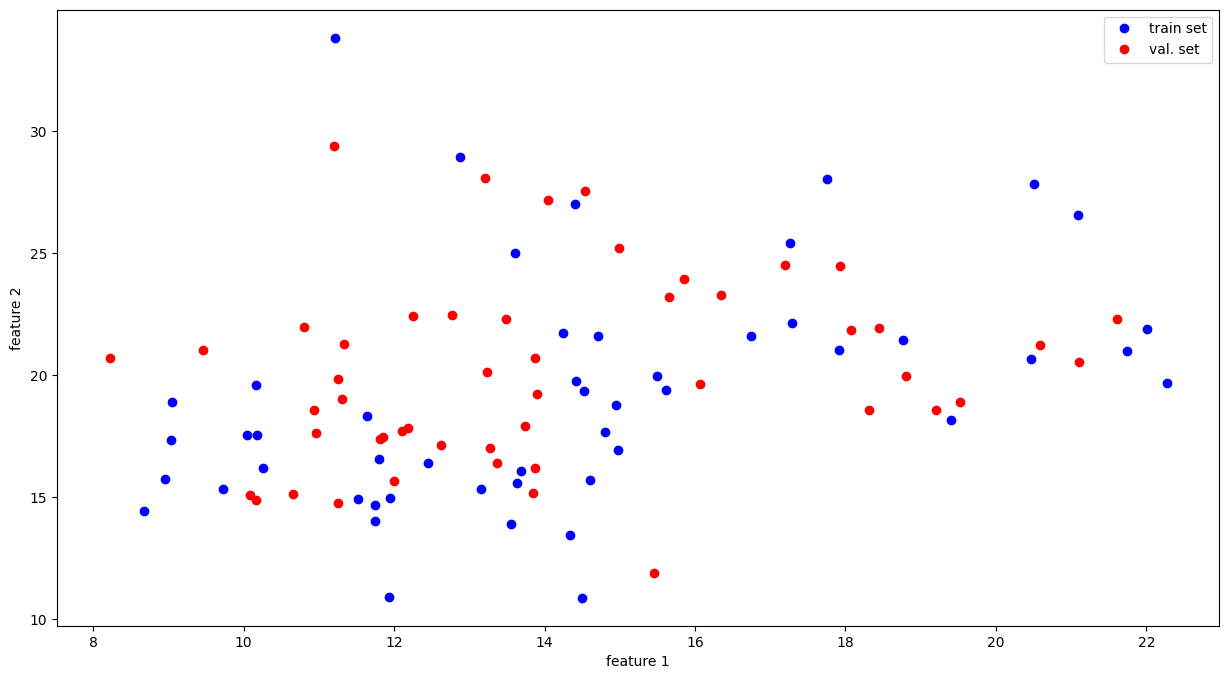

In [22]:
plt.figure(figsize=(15,8))
plt.plot(x_train[:50, 0], x_train[:50, 1], 'bo')
plt.plot(x_val[:50, 0], x_val[:50, 1], 'ro')
plt.xlabel('feature 1')
plt.ylabel('feature 2')
plt.legend(['train set', 'val. set'])
plt.show()

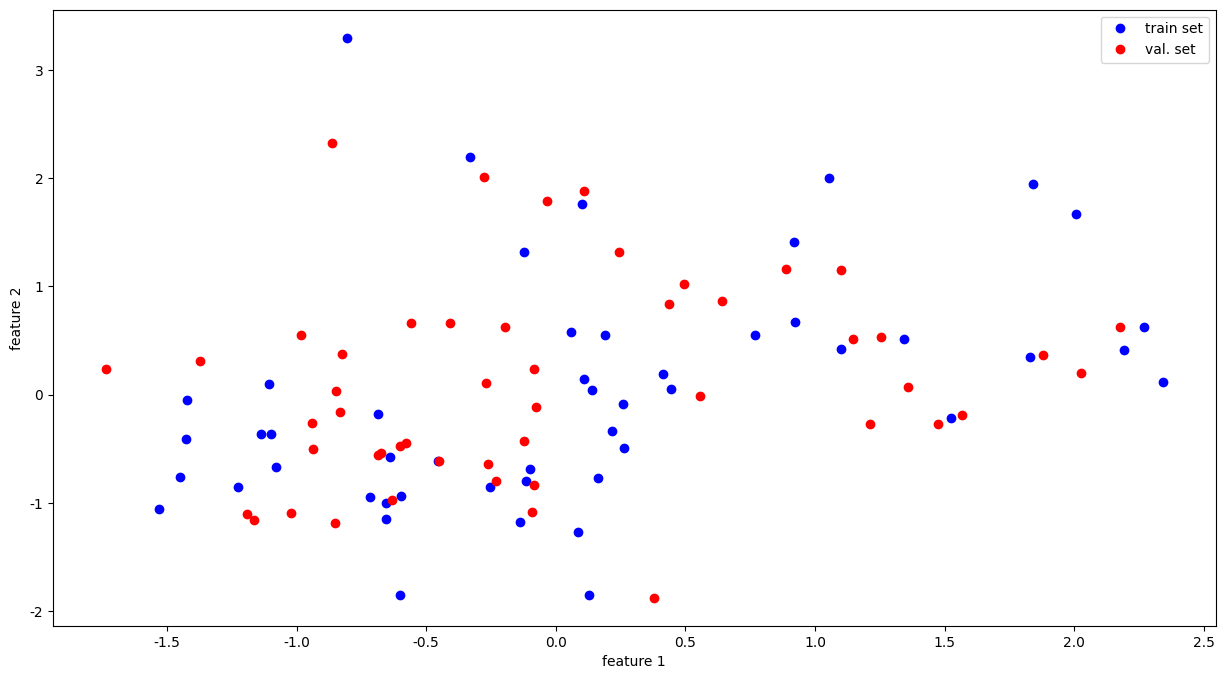

In [23]:
plt.figure(figsize=(15,8))
plt.plot(x_train_scaled[:50, 0], x_train_scaled[:50, 1], 'bo')
plt.plot(x_val_scaled[:50, 0], x_val_scaled[:50, 1], 'ro')
plt.xlabel('feature 1')
plt.ylabel('feature 2')
plt.legend(['train set', 'val. set'])
plt.show()

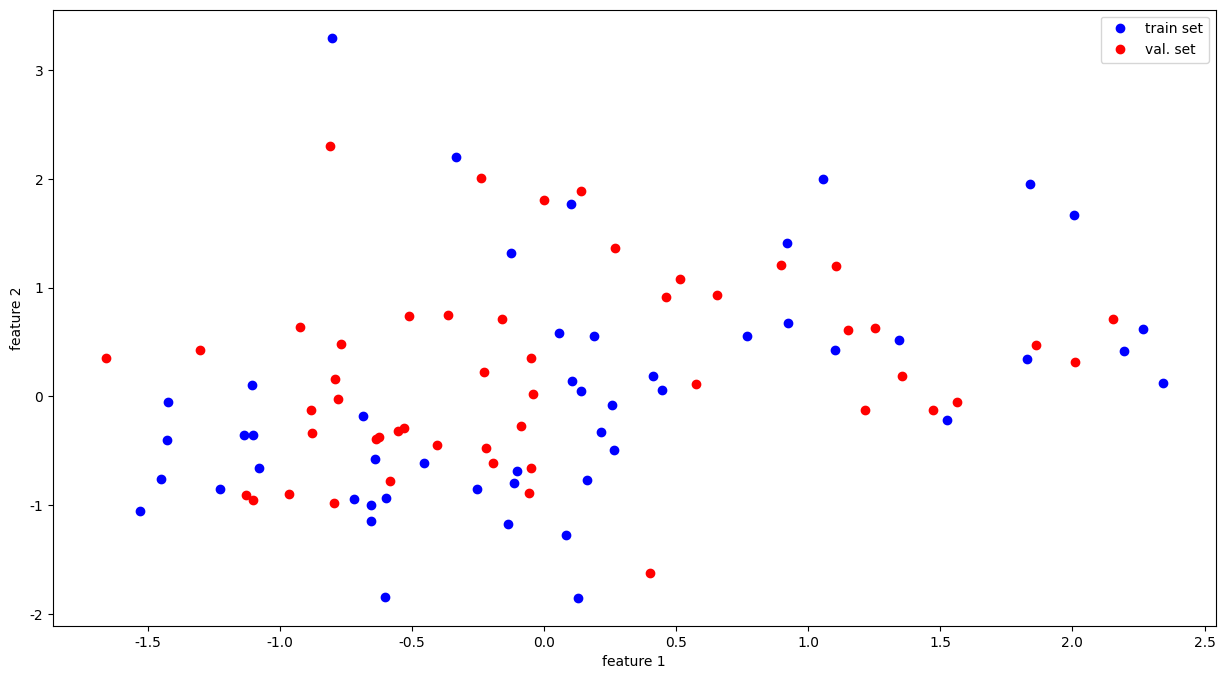

In [24]:
x_val_scaled = (x_val - train_mean) / train_std

plt.figure(figsize=(15,8))
plt.plot(x_train_scaled[:50, 0], x_train_scaled[:50, 1], 'bo')
plt.plot(x_val_scaled[:50, 0], x_val_scaled[:50, 1], 'ro')
plt.xlabel('feature 1')
plt.ylabel('feature 2')
plt.legend(['train set', 'val. set'])
plt.show()

In [25]:
layer2.score(x_val_scaled, y_val)

0.967032967032967

## 05-2 과대적합과 과소적합을 알아봅니다

In [26]:
layer3 = SingleLayer()
layer3.fit(x_train_scaled, y_train, x_val=x_val_scaled, y_val=y_val)

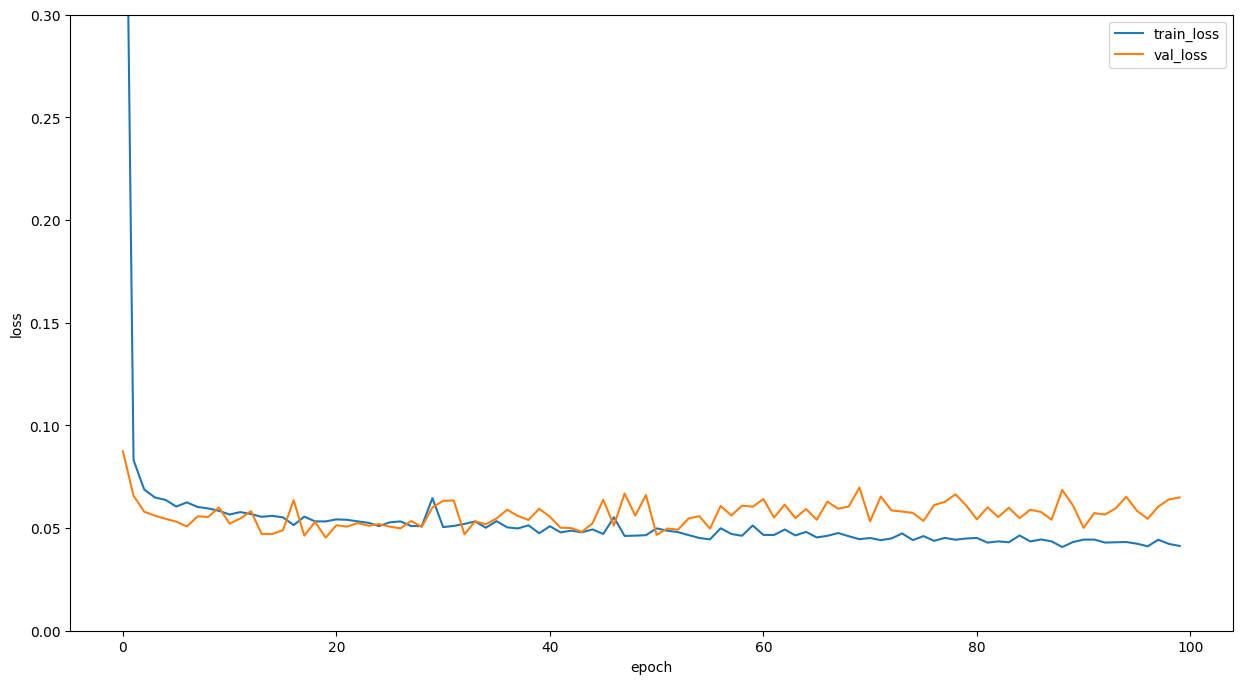

In [27]:
plt.figure(figsize=(15,8))
plt.ylim(0, 0.3)
plt.plot(layer3.losses)
plt.plot(layer3.val_losses)
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train_loss', 'val_loss'])
plt.show()

In [28]:
layer4 = SingleLayer()
layer4.fit(x_train_scaled, y_train, epochs=20)
layer4.score(x_val_scaled, y_val)

0.989010989010989

## 05-3 규제를 알아봅니다

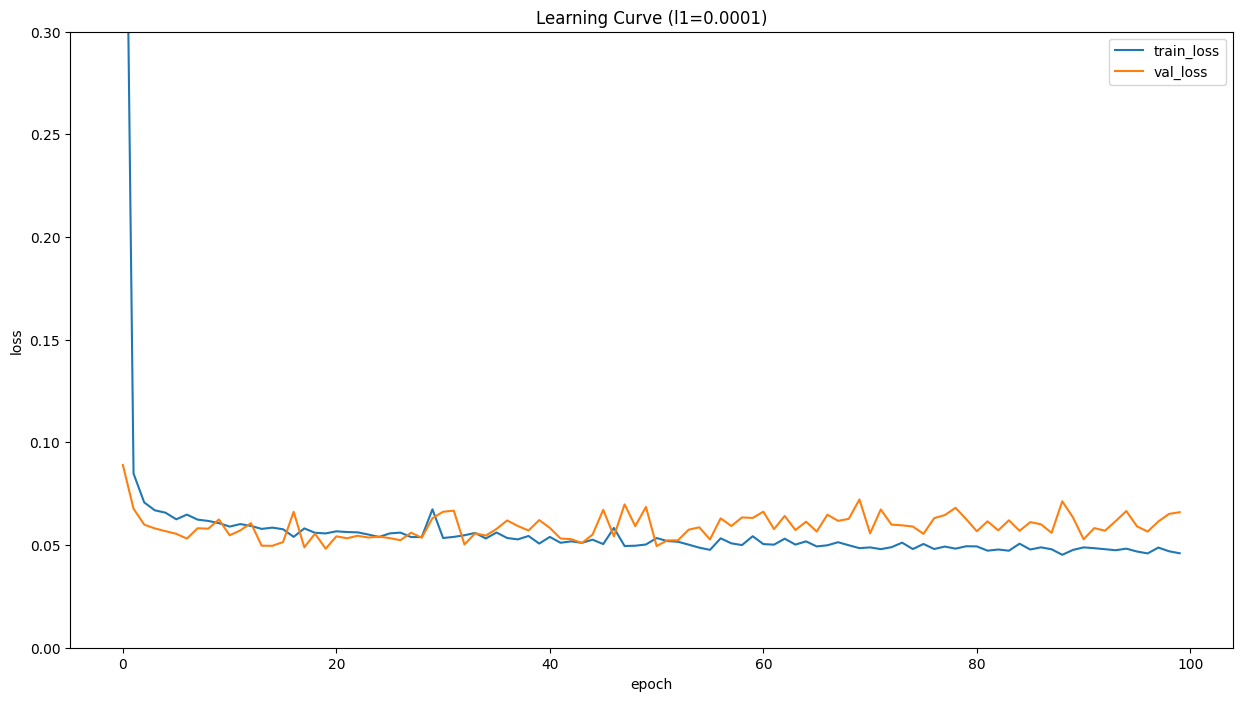

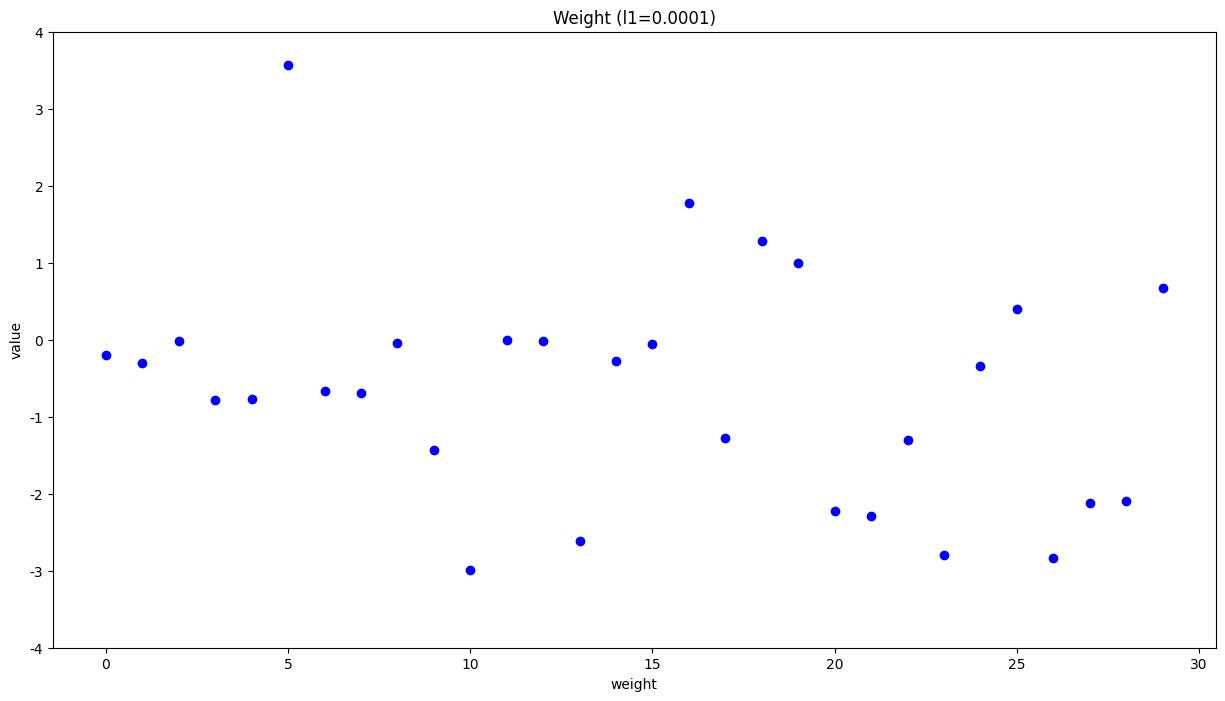

[-2.04005060e-01 -2.96497817e-01 -1.76527193e-02 -7.87254858e-01
 -7.69324522e-01  3.57360483e+00 -6.63236205e-01 -6.86510096e-01
 -4.09665698e-02 -1.43213721e+00 -2.99677830e+00 -1.69790384e-03
 -1.29557289e-02 -2.60883773e+00 -2.78026647e-01 -4.99773076e-02
  1.77394218e+00 -1.27289321e+00  1.28539417e+00  9.95250795e-01
 -2.22465187e+00 -2.28951372e+00 -1.30387000e+00 -2.79251597e+00
 -3.34983739e-01  4.01179325e-01 -2.82853680e+00 -2.11878834e+00
 -2.09207239e+00  6.72761314e-01]


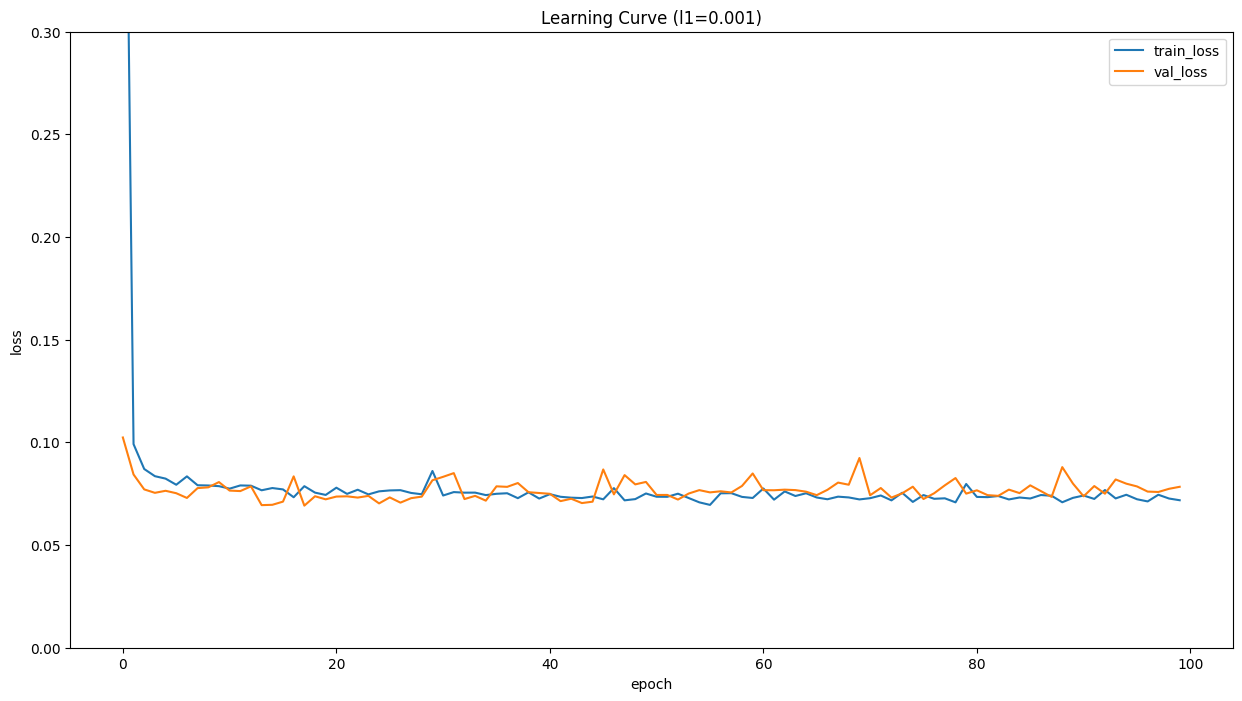

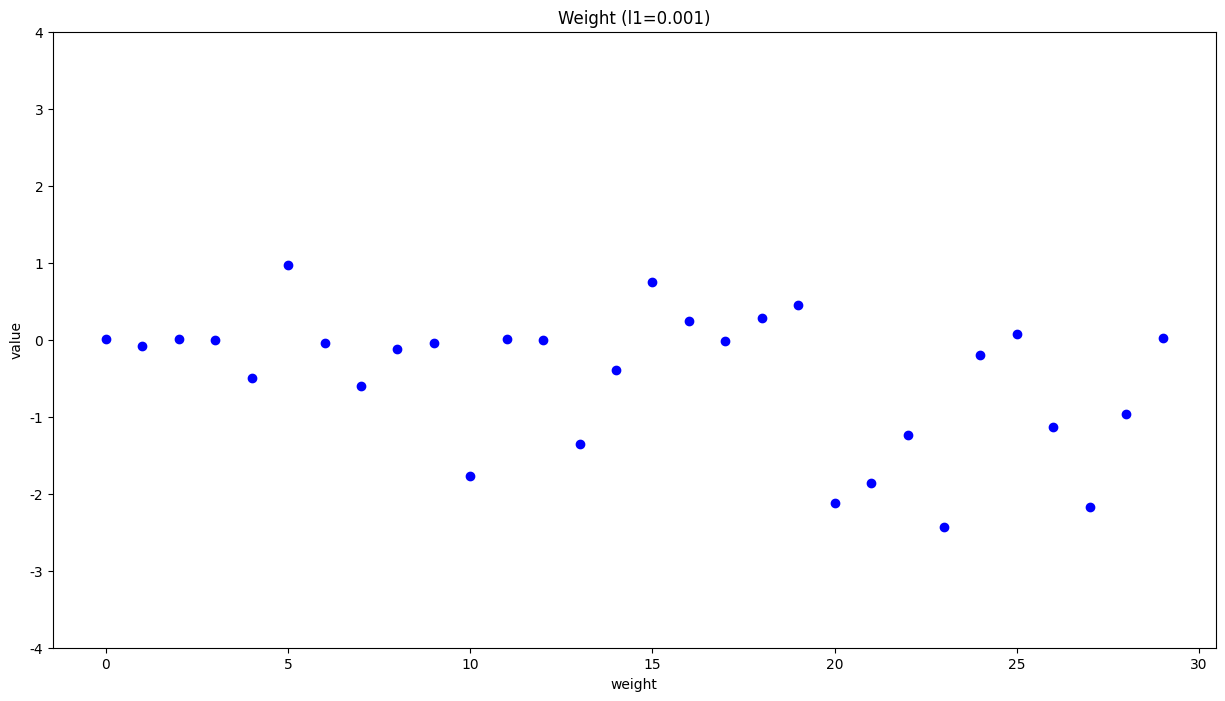

[ 1.15828509e-02 -7.61609721e-02  8.97011241e-03  7.30922517e-05
 -4.99134426e-01  9.73526109e-01 -3.97367184e-02 -5.98553724e-01
 -1.23368989e-01 -3.69367833e-02 -1.76896943e+00  4.44959180e-03
 -4.48114575e-03 -1.35993119e+00 -3.94575918e-01  7.43524552e-01
  2.43039852e-01 -2.11465419e-02  2.85160713e-01  4.46901483e-01
 -2.11978540e+00 -1.86246007e+00 -1.24059947e+00 -2.42798820e+00
 -1.98695836e-01  6.90189801e-02 -1.13470665e+00 -2.17585562e+00
 -9.69112851e-01  2.70396918e-02]


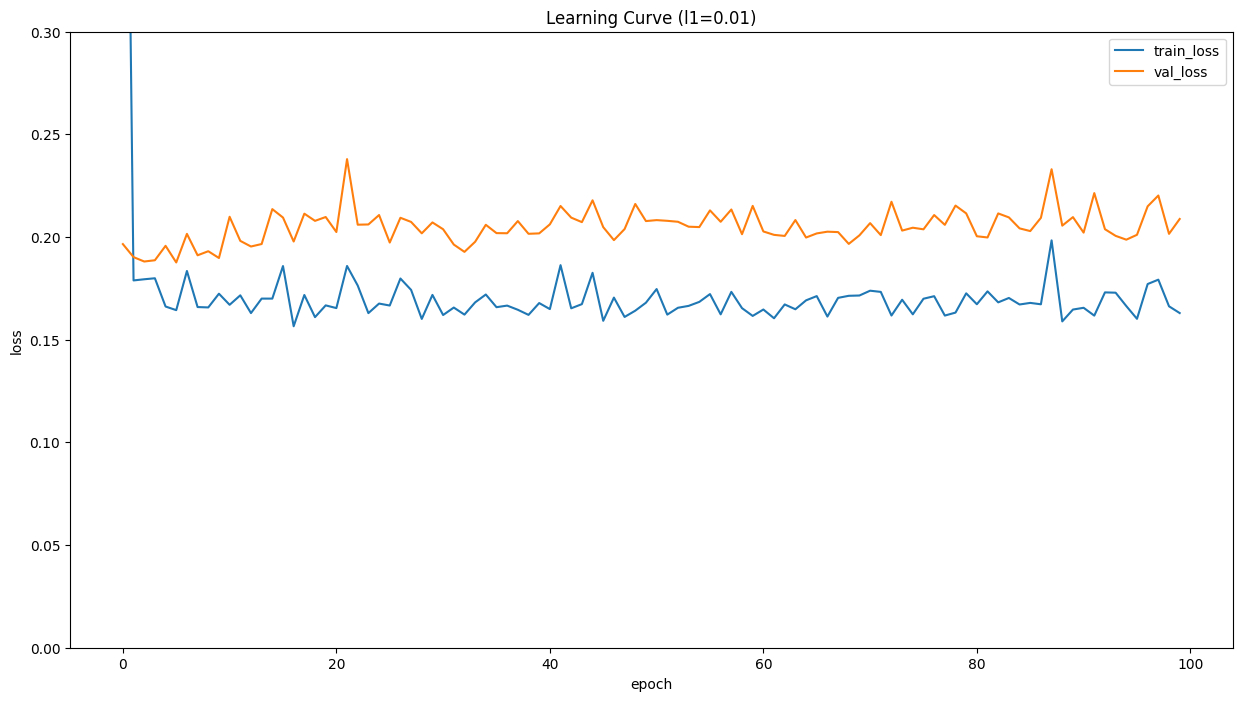

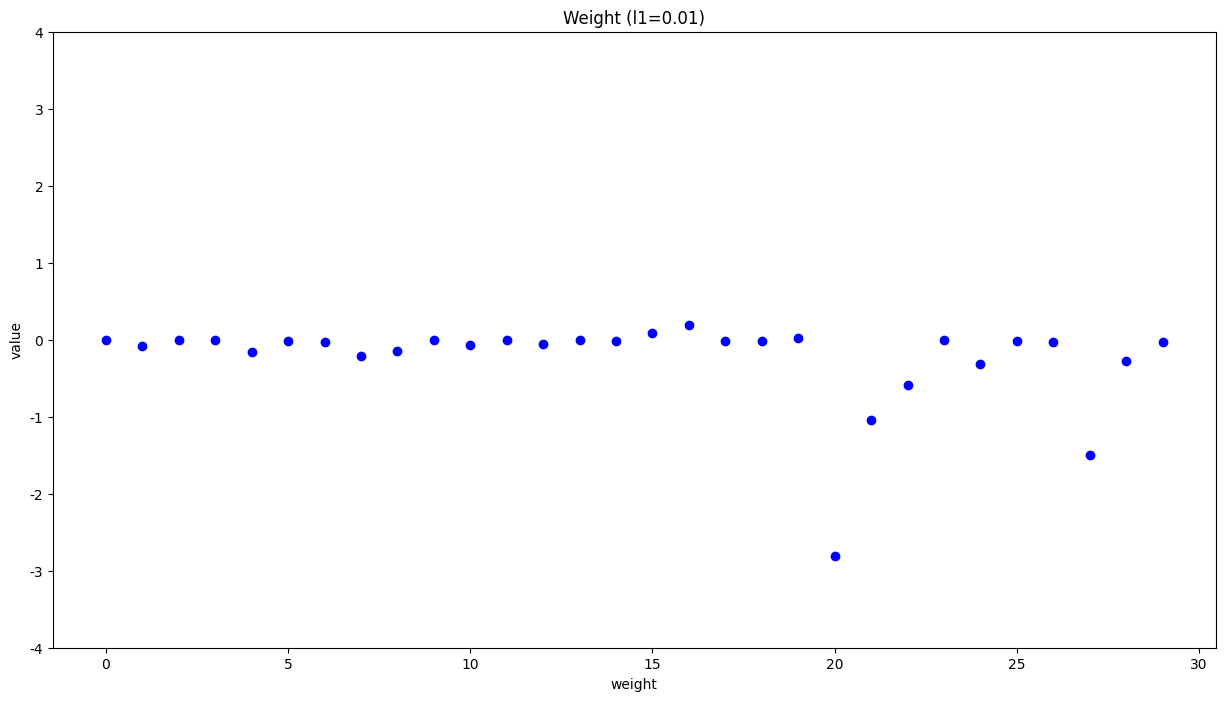

[-2.62010988e-03 -8.76604671e-02 -2.23742134e-03 -1.24508855e-03
 -1.60615320e-01 -1.39222328e-02 -3.30783293e-02 -2.07209599e-01
 -1.52416879e-01 -1.64092580e-04 -7.44067186e-02  1.81449199e-03
 -5.15697784e-02 -4.33980554e-03 -1.01101714e-02  9.23714629e-02
  1.89533010e-01 -1.50930118e-02 -2.16091155e-02  2.86192001e-02
 -2.80741427e+00 -1.03713600e+00 -5.93419566e-01 -3.03282851e-03
 -3.13705637e-01 -2.16031177e-02 -2.94146324e-02 -1.49265783e+00
 -2.76752741e-01 -2.83265423e-02]


In [29]:
l1_list = [0.0001, 0.001, 0.01]

for l1 in l1_list:
    lyr = SingleLayer(l1=l1)
    lyr.fit(x_train_scaled, y_train, x_val=x_val_scaled, y_val=y_val)
    
    plt.figure(figsize=(15,8))
    plt.plot(lyr.losses)
    plt.plot(lyr.val_losses)
    plt.title('Learning Curve (l1={})'.format(l1))
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train_loss', 'val_loss'])
    plt.ylim(0, 0.3)
    plt.show()
    
    plt.figure(figsize=(15,8))
    plt.plot(lyr.w, 'bo')
    plt.title('Weight (l1={})'.format(l1))
    plt.ylabel('value')
    plt.xlabel('weight')
    plt.ylim(-4, 4)
    plt.show()
    print(lyr.w)

In [30]:
layer5 = SingleLayer(l1=0.001)
layer5.fit(x_train_scaled, y_train, epochs=20)
layer5.score(x_val_scaled, y_val)

0.989010989010989

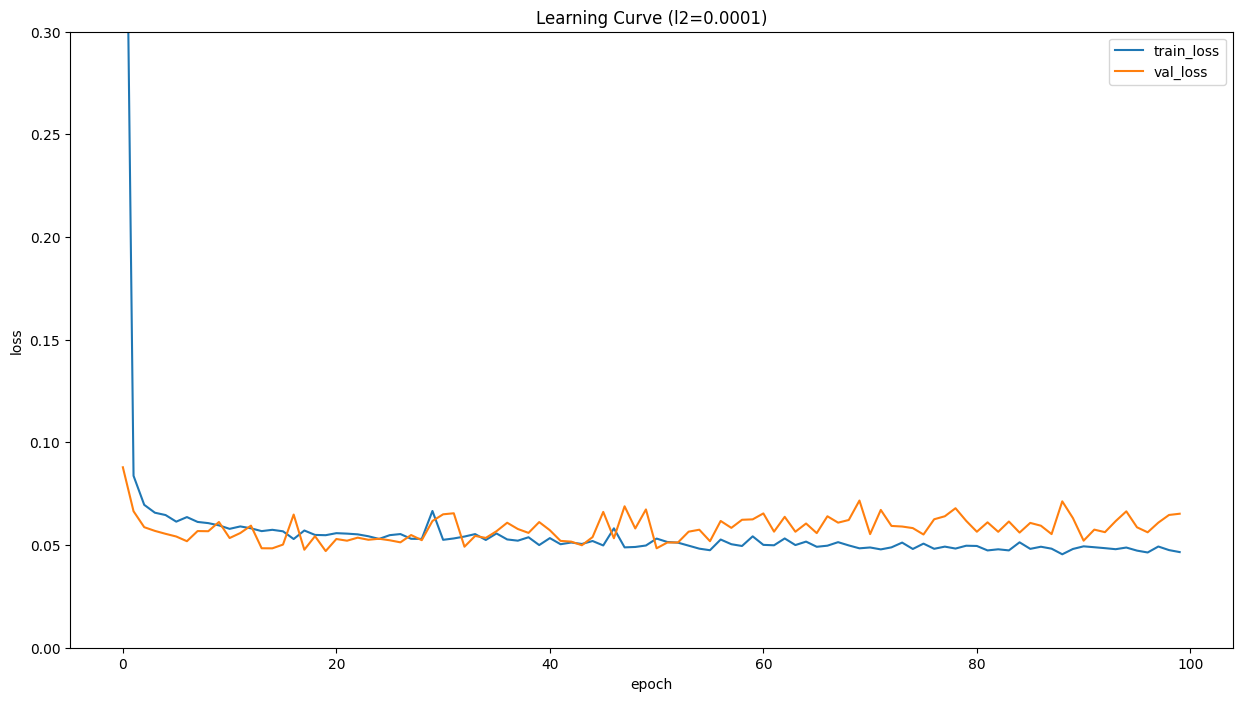

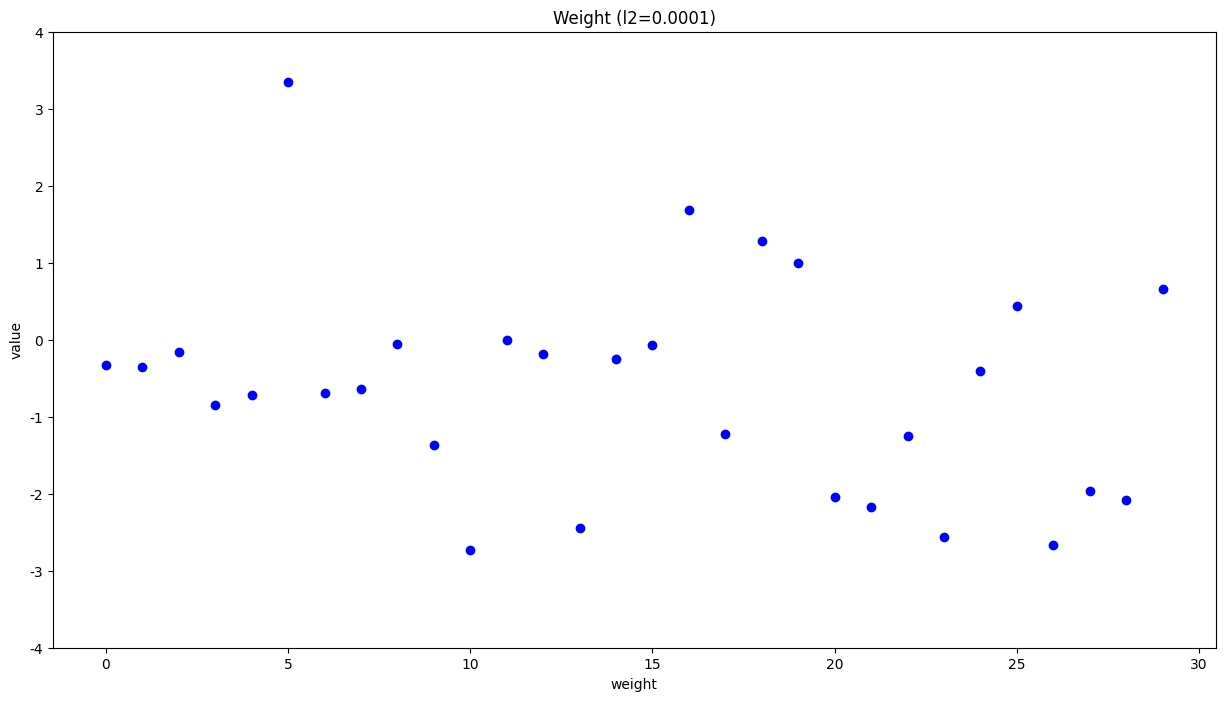

[-3.24773966e-01 -3.59067107e-01 -1.55313664e-01 -8.46195208e-01
 -7.22097460e-01  3.34264095e+00 -6.94535243e-01 -6.43179331e-01
 -5.63225843e-02 -1.36208265e+00 -2.73206986e+00  1.28804208e-03
 -1.90455954e-01 -2.44025876e+00 -2.44218038e-01 -6.59680039e-02
  1.68715975e+00 -1.22320675e+00  1.27846116e+00  1.00101599e+00
 -2.04419175e+00 -2.17462339e+00 -1.25474572e+00 -2.55824073e+00
 -4.09603363e-01  4.39332426e-01 -2.66607204e+00 -1.95902681e+00
 -2.07705335e+00  6.57749139e-01]


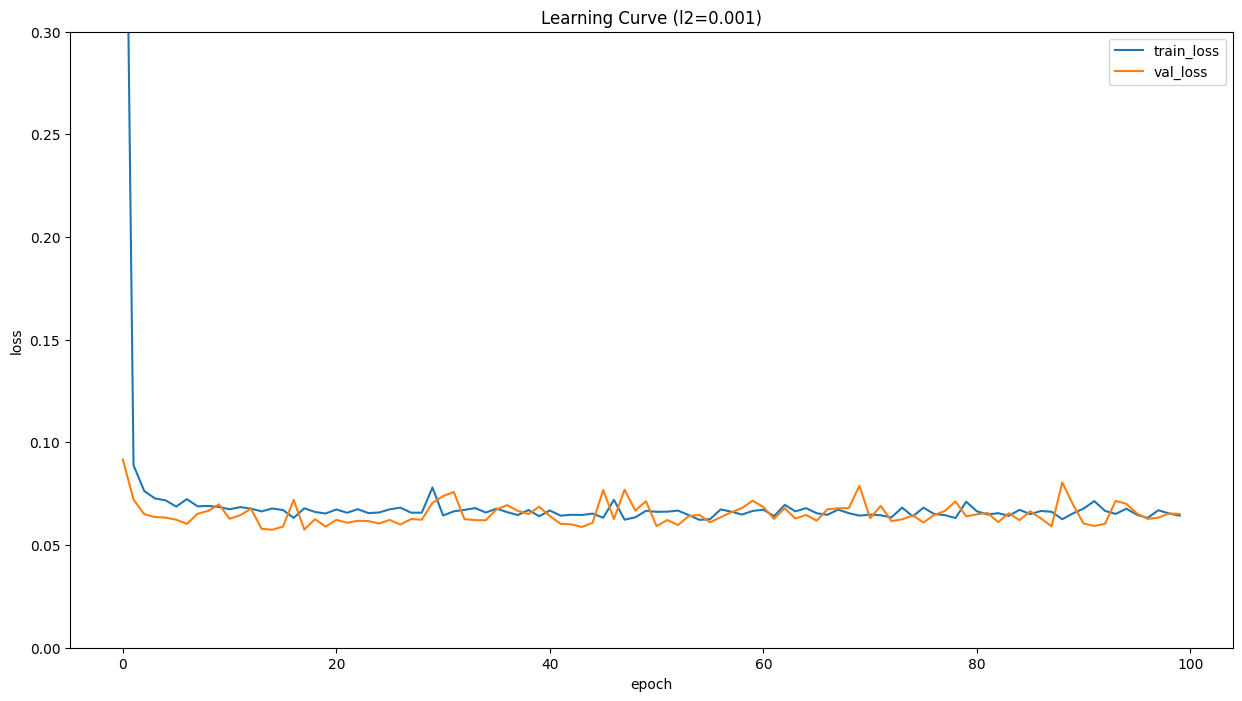

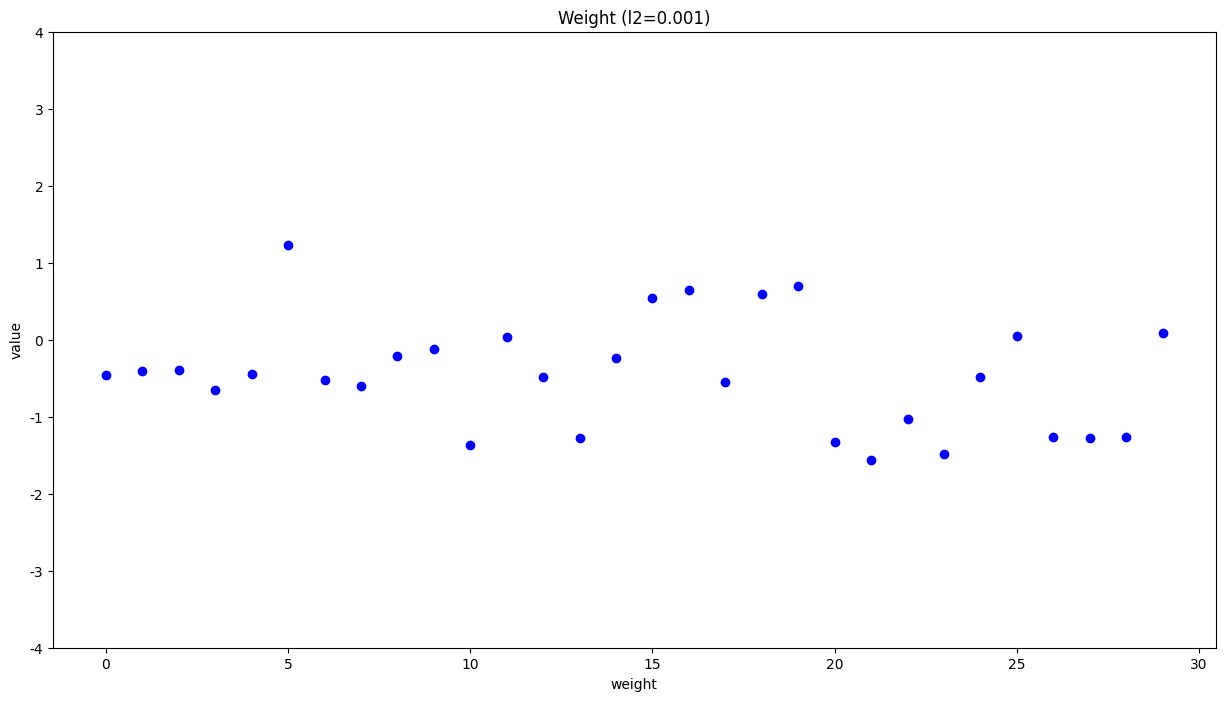

[-0.45671277 -0.40983962 -0.39123542 -0.65905465 -0.4436433   1.23166545
 -0.52765766 -0.60245411 -0.21179563 -0.1254479  -1.37317538  0.03056915
 -0.48765474 -1.28134319 -0.23869384  0.5380056   0.64643667 -0.55413855
  0.59921082  0.69628702 -1.33331207 -1.56421966 -1.02861184 -1.48739988
 -0.48477117  0.04679264 -1.26862401 -1.27757127 -1.2649647   0.08281891]


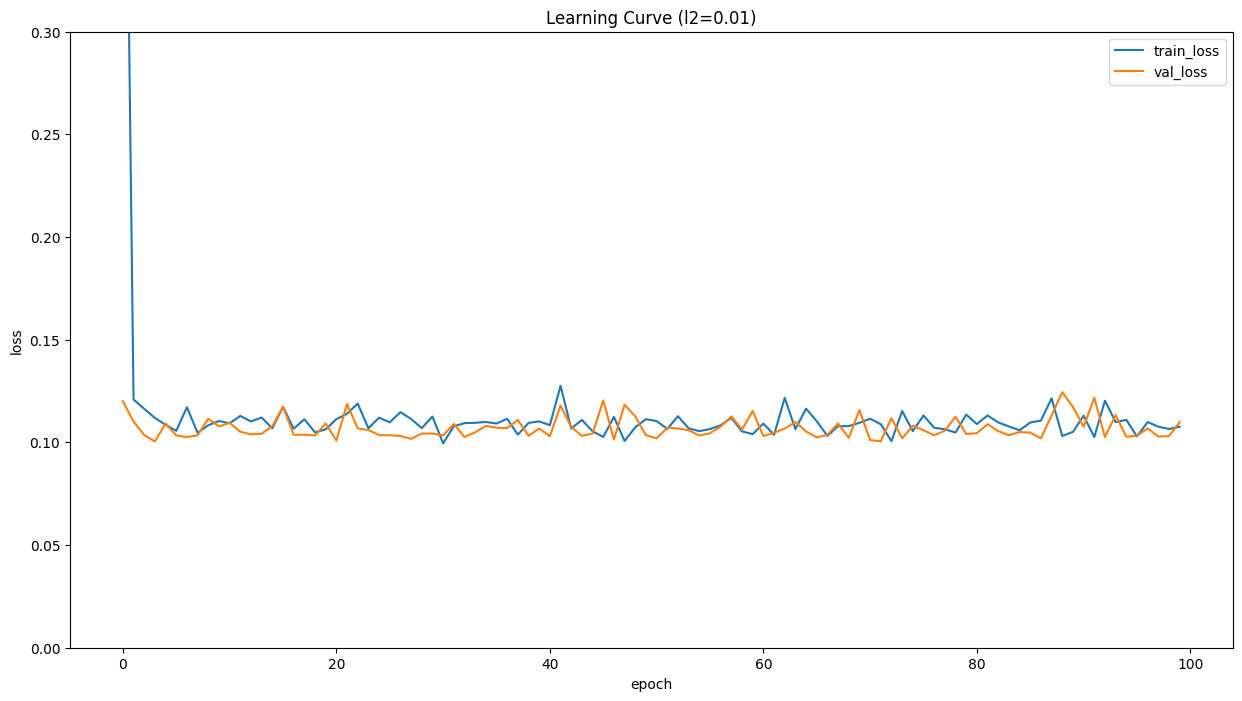

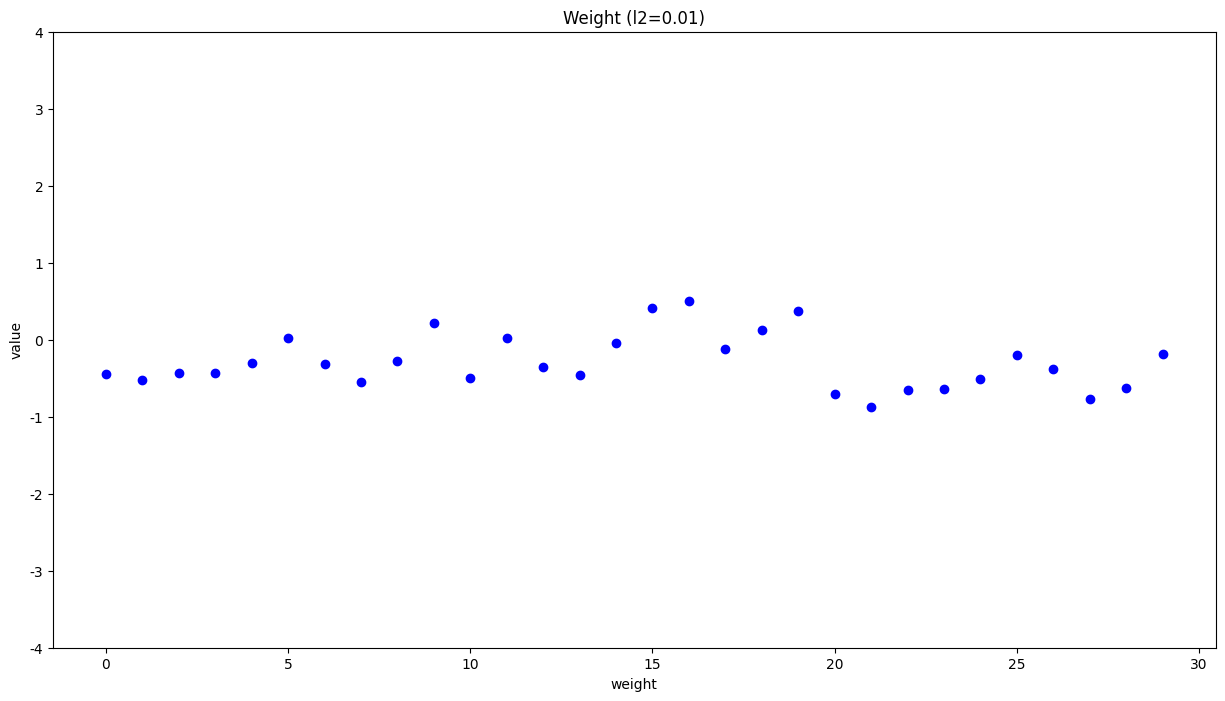

[-0.44331105 -0.52871563 -0.43250855 -0.42951721 -0.29714276  0.0237308
 -0.31568069 -0.55005557 -0.26998147  0.21831272 -0.50178673  0.01778699
 -0.35877648 -0.45224267 -0.04737827  0.41469365  0.49798451 -0.12004843
  0.1313355   0.3727843  -0.70996091 -0.87652674 -0.65792929 -0.64443222
 -0.51419793 -0.202648   -0.37685628 -0.77332184 -0.62959026 -0.18645109]


In [31]:
l2_list = [0.0001, 0.001, 0.01]

for l2 in l2_list:
    lyr = SingleLayer(l2=l2)
    lyr.fit(x_train_scaled, y_train, x_val=x_val_scaled, y_val=y_val)
    
    plt.figure(figsize=(15,8))
    plt.plot(lyr.losses)
    plt.plot(lyr.val_losses)
    plt.title('Learning Curve (l2={})'.format(l2))
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train_loss', 'val_loss'])
    plt.ylim(0, 0.3)
    plt.show()
    
    plt.figure(figsize=(15,8))
    plt.plot(lyr.w, 'bo')
    plt.title('Weight (l2={})'.format(l2))
    plt.ylabel('value')
    plt.xlabel('weight')
    plt.ylim(-4, 4)
    plt.show()
    print(lyr.w)

In [32]:
layer6 = SingleLayer(l2=0.01)
layer6.fit(x_train_scaled, y_train, epochs=50)
layer6.score(x_val_scaled, y_val)

0.989010989010989

In [33]:
np.sum(layer6.predict(x_val_scaled) == y_val)

90

In [34]:
sgd = SGDClassifier(loss='log_loss', penalty='l2', alpha=0.001, random_state=42)
sgd.fit(x_train_scaled, y_train)
sgd.score(x_val_scaled, y_val)

0.978021978021978

## 05-4 교차 검증을 알아봅니다

In [48]:
validation_scores = []

In [49]:
k = 10
bins = len(x_train_all) // k

for i in range(k):
    start = i*bins
    end = (i+1)*bins
    val_fold = x_train_all[start:end]
    val_target = y_train_all[start:end]
    
    train_index = list(range(0, start))+list(range(end, len(x_train_all)))
    train_fold = x_train_all[train_index]
    train_target = y_train_all[train_index]
    
    train_mean = np.mean(train_fold, axis=0)
    train_std = np.std(train_fold, axis=0)
    train_fold_scaled = (train_fold - train_mean) / train_std
    val_fold_scaled = (val_fold - train_mean) / train_std
    
    lyr = SingleLayer(l2=0.01)
    lyr.fit(train_fold_scaled, train_target, epochs=50)
    score = lyr.score(val_fold_scaled, val_target)
    validation_scores.append(score)

print(np.mean(validation_scores))

0.9777777777777779


In [50]:
validation_scores

[0.9333333333333333,
 1.0,
 1.0,
 1.0,
 0.9555555555555556,
 1.0,
 0.9555555555555556,
 0.9777777777777777,
 1.0,
 0.9555555555555556]

In [51]:
from sklearn.model_selection import cross_validate
sgd = SGDClassifier(loss='log_loss', penalty='l2', alpha=0.001, random_state=42)
scores = cross_validate(sgd, x_train_all, y_train_all, cv=10)
print(np.mean(scores['test_score']))

0.850096618357488


In [52]:
type(scores)

dict

In [53]:
scores

{'fit_time': array([0.00324368, 0.00287294, 0.00189686, 0.0021801 , 0.00144196,
        0.00179505, 0.0016439 , 0.00166392, 0.00172091, 0.00120497]),
 'score_time': array([0.00070715, 0.00041795, 0.0004108 , 0.00041485, 0.00029707,
        0.00029588, 0.00024891, 0.00046587, 0.00027299, 0.00027633]),
 'test_score': array([0.86956522, 0.93478261, 0.7826087 , 0.95652174, 0.91304348,
        0.75555556, 0.88888889, 0.6       , 0.95555556, 0.84444444])}

In [54]:
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
pipe = make_pipeline(StandardScaler(), sgd)
scores = cross_validate(pipe, x_train_all, y_train_all, cv=10, return_train_score=True)
print(np.mean(scores['test_score']))

0.9694202898550724


In [56]:
scores

{'fit_time': array([0.00482893, 0.00297093, 0.00240993, 0.00214195, 0.00141072,
        0.00160193, 0.00159907, 0.00171208, 0.00201488, 0.00158787]),
 'score_time': array([0.00053596, 0.00048614, 0.0005312 , 0.00028992, 0.00027609,
        0.00026393, 0.00026202, 0.00043297, 0.00035405, 0.00031376]),
 'test_score': array([0.93478261, 0.95652174, 1.        , 0.95652174, 0.91304348,
        1.        , 1.        , 1.        , 1.        , 0.93333333]),
 'train_score': array([0.99266504, 0.98777506, 0.99022005, 0.98777506, 0.98777506,
        0.98536585, 0.98536585, 0.98780488, 0.98292683, 0.98780488])}

In [55]:
print(np.mean(scores['train_score']))

0.9875478561631581


In [58]:
import numpy as np
from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler, Normalizer

# 샘플 데이터
data = np.array([[1, 2, 3], [4, 5, 6], [7, 8, 9], [10, 11, 12]])

print(data)

# Min-Max Scaler
min_max_scaler = MinMaxScaler()
data_min_max_scaled = min_max_scaler.fit_transform(data)
print("Min-Max Scaled Data:\n", data_min_max_scaled)

# Standard Scaler
standard_scaler = StandardScaler()
data_standard_scaled = standard_scaler.fit_transform(data)
print("Standard Scaled Data:\n", data_standard_scaled)

# Robust Scaler
robust_scaler = RobustScaler()
data_robust_scaled = robust_scaler.fit_transform(data)
print("Robust Scaled Data:\n", data_robust_scaled)

# Normalizer
normalizer = Normalizer()
data_normalized = normalizer.fit_transform(data)
print("Normalized Data:\n", data_normalized)

[[ 1  2  3]
 [ 4  5  6]
 [ 7  8  9]
 [10 11 12]]
Min-Max Scaled Data:
 [[0.         0.         0.        ]
 [0.33333333 0.33333333 0.33333333]
 [0.66666667 0.66666667 0.66666667]
 [1.         1.         1.        ]]
Standard Scaled Data:
 [[-1.34164079 -1.34164079 -1.34164079]
 [-0.4472136  -0.4472136  -0.4472136 ]
 [ 0.4472136   0.4472136   0.4472136 ]
 [ 1.34164079  1.34164079  1.34164079]]
Robust Scaled Data:
 [[-1.         -1.         -1.        ]
 [-0.33333333 -0.33333333 -0.33333333]
 [ 0.33333333  0.33333333  0.33333333]
 [ 1.          1.          1.        ]]
Normalized Data:
 [[0.26726124 0.53452248 0.80178373]
 [0.45584231 0.56980288 0.68376346]
 [0.50257071 0.57436653 0.64616234]
 [0.52342392 0.57576631 0.62810871]]
